In [ ]:
##Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import os
import glob as gb
import glob
import cv2
import PIL
import tensorflow as tf
import seaborn as sns

from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from keras.layers import Flatten,Activation,Dense,Dropout,Conv2D,MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [2]:
trainpath="/kaggle/input/brain-tumor-mri-images/archive (5)/Training/"
testpath="/kaggle/input/brain-tumor-mri-images/archive (5)/Testing/"



# Added Train and Test data folders.

In [58]:
class_names=train_x.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


Class Descriptions = glioma: tumorous, meningioma: benign tumor, notumor: tumorless, pituitary: pituitary gland tumor

We added the label data (class).

In [ ]:
batch_size = 32 #data size
image_h = 224
image_w = 224

Sizing data and adjusting images in height and width

In [ ]:
train_x = tf.keras.utils.image_dataset_from_directory( 
    #library used to load images
    trainpath,
    validation_split=0.2, #data partitioning
    subset="training",
    seed=143, #number of training steps in the model
    image_size=(image_h, image_w),
    batch_size=batch_size,
    label_mode= 'int'
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


2023-01-09 19:00:22.062262: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Splitting the dataset into trains


In [ ]:
val_data = tf.keras.utils.image_dataset_from_directory(
    trainpath,
    validation_split=0.2,#data partitioning
    subset="validation",
    seed=143,#number of steps to train the model
    image_size=(image_h, image_w),
    batch_size=batch_size,
    label_mode= 'int'
)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


Using validation to check if the entered data type is correct

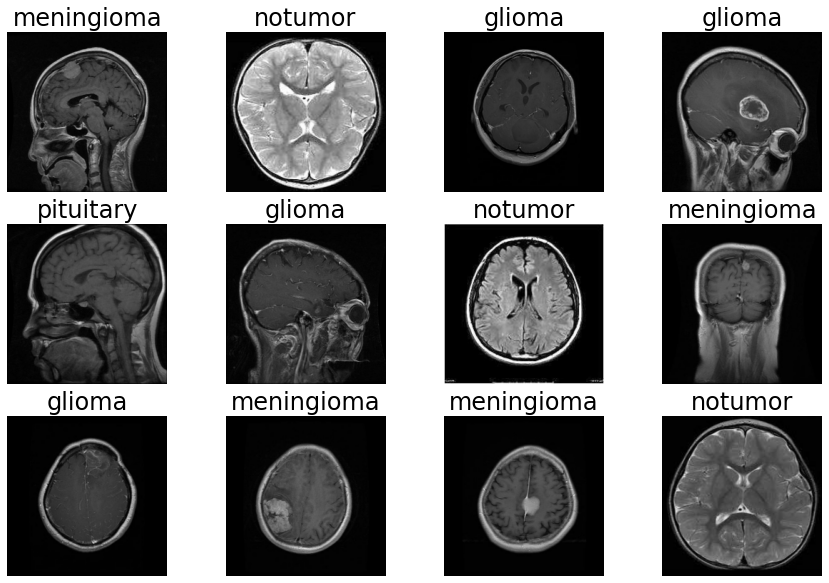

In [ ]:
plt.figure(figsize=(15, 10))
for images, labels in train_x.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off") 
        
#The take function is used to view some images.
#Since .take(1) is used here, 1 chunk of size 32 will be selected.        

In [17]:
meningioma = 0
notumor = 0
glioma = 0
pituitary = 0

for images, labels in train_x:
    for i in range(len(images)):
        if class_names[labels[i]] == 'meningioma':
            meningioma +=1
        elif class_names[labels[i]] == 'notumor':
            notumor +=1
        elif class_names[labels[i]] == 'glioma':
            glioma +=1
        elif class_names[labels[i]] == 'pituitary':
            pituitary +=1
            
            
print('meningioma : ', meningioma)
print('glioma : ', glioma)
print('pituitary : ', pituitary)
print('notumor : ', notumor)

Cleanup called...
Cleanup called...


meningioma :  1073
glioma :  1055
pituitary :  1157
notumor :  1285


We found out which class the images in the train belong to.

# Creating a Model

In [ ]:
from keras.applications import densenet
from keras.initializers import GlorotNormal #Normal starter
d = densenet.DenseNet121(weights=None, #weights to be loaded
    include_top = False # The fully connected layer is not included in the network.
    , input_shape = (224, 224, 3)) #determining the size of input values
k = tf.keras.layers.Dropout(0.8)(d.output) # Improving training performance by randomly removing connections
k = tf.keras.layers.GlobalAveragePooling2D(name = "GlobalAveragePooling2D_")(k) # max pooling process to matrix conversion                      
k = tf.keras.layers.Dropout(0.8)(k)
k = tf.keras.layers.Dense(4 #class 
                        , kernel_initializer=GlorotNormal(),
activation = 'softmax', kernel_regularizer= tf.keras.regularizers.L2(0.0001),# parameter to reduce the loss value
                          bias_regularizer= tf.keras.regularizers.L2(0.0001))(k) #output passes through origin
k = tf.keras.models.Model(inputs = d.input, outputs = k)
k.load_weights("../input/brain-tumor-mri-images/ednet_weights/ednet_weights_optim.h5", by_name=True, skip_mismatch=True)
for layer in k.layers[:200]: #Trained layer
    layer.trainable = False #We froze the trained data.
for layer in k.layers[200:]: #Layer to be Trained
    layer.trainable = True #training the new layer.

We froze the pre-trained data to avoid destroying any information when it was to be trained again.

Softmax: It is used to normalize by converting weighted sum values ​​into probabilities that sum to one.

In [14]:
k.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
#Two arguments required to compile the Keras model
k.compile(optimizer= tf.keras.optimizers.Adam(0.001), 
          loss = 'sparse_categorical_crossentropy', 
          metrics = ['accuracy']) #doğruluk

# Compile the Model

In [ ]:
history = k.fit(train_x, epochs =23 , batch_size = batch_size,
                  validation_data = val_data,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 14,monitor = 'val_loss', restore_best_weights=True)])
#Stopping training when a tracked metric stops improving.

Epoch 1/23
 21/143 [===>..........................] - ETA: 6:12 - loss: 0.1879 - accuracy: 0.9330

Cleanup called...


 49/143 [=========>....................] - ETA: 4:46 - loss: 0.1786 - accuracy: 0.9394

Cleanup called...


143/143 [==============================] - ETA: 0s - loss: 0.1774 - accuracy: 0.9387

Cleanup called...
Cleanup called...
Cleanup called...


143/143 [==============================] - 554s 4s/step - loss: 0.1774 - accuracy: 0.9387 - val_loss: 0.2173 - val_accuracy: 0.9291
Epoch 2/23
 21/143 [===>..........................] - ETA: 6:11 - loss: 0.1256 - accuracy: 0.9598

Cleanup called...


 49/143 [=========>....................] - ETA: 4:45 - loss: 0.1434 - accuracy: 0.9522

Cleanup called...


143/143 [==============================] - ETA: 0s - loss: 0.1762 - accuracy: 0.9422

Cleanup called...
Cleanup called...
Cleanup called...


143/143 [==============================] - 500s 4s/step - loss: 0.1762 - accuracy: 0.9422 - val_loss: 0.2944 - val_accuracy: 0.9107
Epoch 3/23
 21/143 [===>..........................] - ETA: 6:11 - loss: 0.1271 - accuracy: 0.9598

Cleanup called...


 49/143 [=========>....................] - ETA: 4:46 - loss: 0.1425 - accuracy: 0.9503

Cleanup called...


143/143 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.9433

Cleanup called...
Cleanup called...
Cleanup called...


143/143 [==============================] - 500s 4s/step - loss: 0.1543 - accuracy: 0.9433 - val_loss: 0.2377 - val_accuracy: 0.9247
Epoch 4/23
 21/143 [===>..........................] - ETA: 6:12 - loss: 0.1519 - accuracy: 0.9464

Cleanup called...


 49/143 [=========>....................] - ETA: 4:46 - loss: 0.1524 - accuracy: 0.9464

Cleanup called...


143/143 [==============================] - ETA: 0s - loss: 0.1406 - accuracy: 0.9523

Cleanup called...
Cleanup called...
Cleanup called...


143/143 [==============================] - 500s 4s/step - loss: 0.1406 - accuracy: 0.9523 - val_loss: 0.2381 - val_accuracy: 0.9247
Epoch 5/23
 21/143 [===>..........................] - ETA: 6:11 - loss: 0.1187 - accuracy: 0.9539

Cleanup called...


 49/143 [=========>....................] - ETA: 4:46 - loss: 0.1011 - accuracy: 0.9611

Cleanup called...


143/143 [==============================] - ETA: 0s - loss: 0.1035 - accuracy: 0.9628

Cleanup called...
Cleanup called...
Cleanup called...


143/143 [==============================] - 499s 3s/step - loss: 0.1035 - accuracy: 0.9628 - val_loss: 0.2450 - val_accuracy: 0.9361
Epoch 6/23
 21/143 [===>..........................] - ETA: 6:12 - loss: 0.1000 - accuracy: 0.9628

Cleanup called...


 49/143 [=========>....................] - ETA: 4:45 - loss: 0.0989 - accuracy: 0.9643

Cleanup called...


143/143 [==============================] - ETA: 0s - loss: 0.1119 - accuracy: 0.9593

Cleanup called...
Cleanup called...
Cleanup called...


143/143 [==============================] - 497s 3s/step - loss: 0.1119 - accuracy: 0.9593 - val_loss: 0.2392 - val_accuracy: 0.9466
Epoch 7/23
 21/143 [===>..........................] - ETA: 6:11 - loss: 0.0962 - accuracy: 0.9792

Cleanup called...


 49/143 [=========>....................] - ETA: 4:45 - loss: 0.0952 - accuracy: 0.9758

Cleanup called...


143/143 [==============================] - ETA: 0s - loss: 0.0872 - accuracy: 0.9746

Cleanup called...
Cleanup called...
Cleanup called...


143/143 [==============================] - 503s 4s/step - loss: 0.0872 - accuracy: 0.9746 - val_loss: 0.2133 - val_accuracy: 0.9448
Epoch 8/23
 21/143 [===>..........................] - ETA: 6:15 - loss: 0.0767 - accuracy: 0.9762

Cleanup called...


 49/143 [=========>....................] - ETA: 4:47 - loss: 0.0539 - accuracy: 0.9828

Cleanup called...


143/143 [==============================] - ETA: 0s - loss: 0.0903 - accuracy: 0.9731

Cleanup called...
Cleanup called...
Cleanup called...


143/143 [==============================] - 502s 4s/step - loss: 0.0903 - accuracy: 0.9731 - val_loss: 0.2433 - val_accuracy: 0.9352
Epoch 9/23
 21/143 [===>..........................] - ETA: 6:08 - loss: 0.1513 - accuracy: 0.9494

Cleanup called...


 49/143 [=========>....................] - ETA: 4:44 - loss: 0.1194 - accuracy: 0.9617

Cleanup called...


143/143 [==============================] - ETA: 0s - loss: 0.0957 - accuracy: 0.9672

Cleanup called...
Cleanup called...
Cleanup called...


143/143 [==============================] - 498s 3s/step - loss: 0.0957 - accuracy: 0.9672 - val_loss: 0.2078 - val_accuracy: 0.9475
Epoch 10/23
 21/143 [===>..........................] - ETA: 6:12 - loss: 0.0810 - accuracy: 0.9777

Cleanup called...


 49/143 [=========>....................] - ETA: 4:46 - loss: 0.0726 - accuracy: 0.9790

Cleanup called...


143/143 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9772

Cleanup called...
Cleanup called...
Cleanup called...


143/143 [==============================] - 501s 4s/step - loss: 0.0684 - accuracy: 0.9772 - val_loss: 0.2268 - val_accuracy: 0.9431
Epoch 11/23
 21/143 [===>..........................] - ETA: 6:11 - loss: 0.0820 - accuracy: 0.9643

Cleanup called...


 49/143 [=========>....................] - ETA: 4:46 - loss: 0.0890 - accuracy: 0.9694

Cleanup called...


143/143 [==============================] - ETA: 0s - loss: 0.0821 - accuracy: 0.9746

Cleanup called...
Cleanup called...
Cleanup called...


143/143 [==============================] - 500s 3s/step - loss: 0.0821 - accuracy: 0.9746 - val_loss: 0.2453 - val_accuracy: 0.9378
Epoch 12/23
 21/143 [===>..........................] - ETA: 6:11 - loss: 0.0487 - accuracy: 0.9851

Cleanup called...


 49/143 [=========>....................] - ETA: 4:46 - loss: 0.0459 - accuracy: 0.9841

Cleanup called...


143/143 [==============================] - ETA: 0s - loss: 0.0526 - accuracy: 0.9816

Cleanup called...
Cleanup called...
Cleanup called...


143/143 [==============================] - 501s 4s/step - loss: 0.0526 - accuracy: 0.9816 - val_loss: 0.2861 - val_accuracy: 0.9335
Epoch 13/23
 21/143 [===>..........................] - ETA: 6:11 - loss: 0.0427 - accuracy: 0.9881

Cleanup called...


 49/143 [=========>....................] - ETA: 4:47 - loss: 0.0369 - accuracy: 0.9885

Cleanup called...


143/143 [==============================] - ETA: 0s - loss: 0.0580 - accuracy: 0.9816

Cleanup called...
Cleanup called...
Cleanup called...


143/143 [==============================] - 503s 4s/step - loss: 0.0580 - accuracy: 0.9816 - val_loss: 0.6671 - val_accuracy: 0.8739
Epoch 14/23
 21/143 [===>..........................] - ETA: 6:13 - loss: 0.0926 - accuracy: 0.9732

Cleanup called...


 49/143 [=========>....................] - ETA: 4:48 - loss: 0.0657 - accuracy: 0.9790

Cleanup called...


143/143 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.9788

Cleanup called...
Cleanup called...
Cleanup called...


143/143 [==============================] - 504s 4s/step - loss: 0.0641 - accuracy: 0.9788 - val_loss: 0.3867 - val_accuracy: 0.9273
Epoch 15/23
 21/143 [===>..........................] - ETA: 6:13 - loss: 0.0362 - accuracy: 0.9881

Cleanup called...


 49/143 [=========>....................] - ETA: 4:49 - loss: 0.0343 - accuracy: 0.9872

Cleanup called...


143/143 [==============================] - ETA: 0s - loss: 0.0485 - accuracy: 0.9842

Cleanup called...
Cleanup called...
Cleanup called...


143/143 [==============================] - 505s 4s/step - loss: 0.0485 - accuracy: 0.9842 - val_loss: 0.2489 - val_accuracy: 0.9387
Epoch 16/23
 21/143 [===>..........................] - ETA: 6:14 - loss: 0.0427 - accuracy: 0.9836

Cleanup called...


 49/143 [=========>....................] - ETA: 4:46 - loss: 0.0498 - accuracy: 0.9815

Cleanup called...


143/143 [==============================] - ETA: 0s - loss: 0.0516 - accuracy: 0.9832

Cleanup called...
Cleanup called...
Cleanup called...


143/143 [==============================] - 500s 3s/step - loss: 0.0516 - accuracy: 0.9832 - val_loss: 0.2217 - val_accuracy: 0.9492
Epoch 17/23
 21/143 [===>..........................] - ETA: 6:09 - loss: 0.0776 - accuracy: 0.9732

Cleanup called...


 49/143 [=========>....................] - ETA: 4:46 - loss: 0.0542 - accuracy: 0.9834

Cleanup called...


143/143 [==============================] - ETA: 0s - loss: 0.0478 - accuracy: 0.9847

Cleanup called...
Cleanup called...
Cleanup called...


143/143 [==============================] - 500s 3s/step - loss: 0.0478 - accuracy: 0.9847 - val_loss: 0.2710 - val_accuracy: 0.9518
Epoch 18/23
 21/143 [===>..........................] - ETA: 6:09 - loss: 0.0308 - accuracy: 0.9896

Cleanup called...


 49/143 [=========>....................] - ETA: 4:43 - loss: 0.0270 - accuracy: 0.9911

Cleanup called...


143/143 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9845

Cleanup called...
Cleanup called...
Cleanup called...


143/143 [==============================] - 503s 4s/step - loss: 0.0536 - accuracy: 0.9845 - val_loss: 0.2597 - val_accuracy: 0.9501
Epoch 19/23
 21/143 [===>..........................] - ETA: 6:19 - loss: 0.0727 - accuracy: 0.9762

Cleanup called...


 49/143 [=========>....................] - ETA: 4:49 - loss: 0.0540 - accuracy: 0.9834

Cleanup called...


143/143 [==============================] - ETA: 0s - loss: 0.0579 - accuracy: 0.9825

Cleanup called...
Cleanup called...
Cleanup called...


143/143 [==============================] - 505s 4s/step - loss: 0.0579 - accuracy: 0.9825 - val_loss: 0.4527 - val_accuracy: 0.9107
Epoch 20/23
 21/143 [===>..........................] - ETA: 6:14 - loss: 0.0555 - accuracy: 0.9777

Cleanup called...


 49/143 [=========>....................] - ETA: 4:48 - loss: 0.0387 - accuracy: 0.9860

Cleanup called...


143/143 [==============================] - ETA: 0s - loss: 0.0289 - accuracy: 0.9902

Cleanup called...
Cleanup called...
Cleanup called...


143/143 [==============================] - 502s 4s/step - loss: 0.0289 - accuracy: 0.9902 - val_loss: 0.2636 - val_accuracy: 0.9466
Epoch 21/23
 21/143 [===>..........................] - ETA: 6:10 - loss: 0.0155 - accuracy: 0.9955

Cleanup called...


 49/143 [=========>....................] - ETA: 4:45 - loss: 0.0191 - accuracy: 0.9949

Cleanup called...


143/143 [==============================] - ETA: 0s - loss: 0.0408 - accuracy: 0.9871

Cleanup called...
Cleanup called...
Cleanup called...


143/143 [==============================] - 501s 4s/step - loss: 0.0408 - accuracy: 0.9871 - val_loss: 0.3307 - val_accuracy: 0.9229
Epoch 22/23
 21/143 [===>..........................] - ETA: 6:10 - loss: 0.1458 - accuracy: 0.9643

Cleanup called...


 49/143 [=========>....................] - ETA: 4:45 - loss: 0.0909 - accuracy: 0.9739

Cleanup called...


143/143 [==============================] - ETA: 0s - loss: 0.0654 - accuracy: 0.9805

Cleanup called...
Cleanup called...
Cleanup called...


143/143 [==============================] - 499s 3s/step - loss: 0.0654 - accuracy: 0.9805 - val_loss: 0.3073 - val_accuracy: 0.9387
Epoch 23/23
 21/143 [===>..........................] - ETA: 6:09 - loss: 0.0325 - accuracy: 0.9851

Cleanup called...


 49/143 [=========>....................] - ETA: 4:45 - loss: 0.0273 - accuracy: 0.9885

Cleanup called...


143/143 [==============================] - ETA: 0s - loss: 0.0290 - accuracy: 0.9897

Cleanup called...
Cleanup called...
Cleanup called...


143/143 [==============================] - 500s 3s/step - loss: 0.0290 - accuracy: 0.9897 - val_loss: 0.2481 - val_accuracy: 0.9475


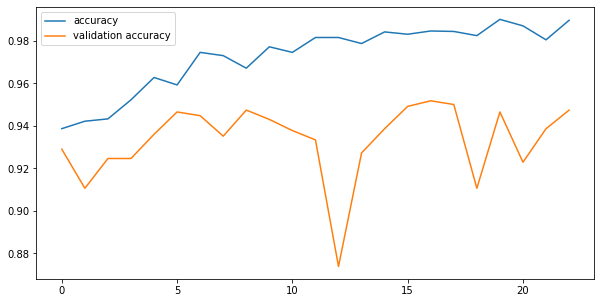

In [24]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label= "accuracy")
plt.plot(history.history['val_accuracy'],label="validation accuracy")
plt.legend()

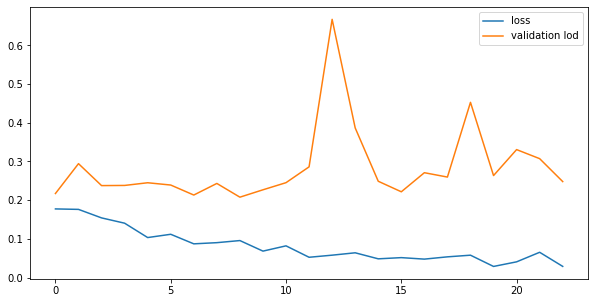

In [25]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label= "loss")
plt.plot(history.history['val_loss'],label="validation lod")
plt.legend()

In [23]:
test_x = tf.keras.utils.image_dataset_from_directory(
    testpath,
    seed=115,
    image_size=(image_h, image_w),
    batch_size=batch_size,
    label_mode= 'int'
)

Found 1311 files belonging to 4 classes.


In [ ]:
loss, accuracy = k.evaluate(test_x) # performance measure of test data

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))


41/41 [==============================] - 75s 2s/step - loss: 0.1872 - accuracy: 0.9443

Loss on the TEST Set: 0.187
Accuracy on the TEST Set: 94.432%


In [112]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [113]:
print(labels)

['glioma', 'meningioma', 'notumor', 'pituitary']


# 🎰 Creating Real Vectors

In [ ]:
#Creating Numpy array with indexes of True classes
y_true = np.random.randint(low=0, high=4, size=100, dtype=int)



print(y_true)

[3 1 1 0 2 0 3 2 3 2 2 0 0 1 1 0 0 0 3 3 0 1 1 0 2 0 2 1 3 0 1 1 0 1 0 2 1
 2 1 1 2 1 2 1 2 2 2 3 1 3 2 3 3 0 2 3 0 3 1 2 2 2 1 2 1 3 3 0 3 1 2 2 2 0
 1 3 3 2 3 0 2 1 2 2 3 0 1 3 2 3 1 0 0 2 2 3 3 2 1 2]


# 📊 Showing the distribution of examples across classes

In [ ]:
# Calculating the number of samples for each class
# Iterate through indices of all classes in array 'y_true'
# Using the Numpy function 'unique'
# Returning ranked unique elements and their frequencies
classesIndexes, classesFrequency = np.unique(y_true, return_counts=True)


# Print frequency (number of samples) for each class
print('classes indexes:' , classesIndexes)
print('\n')
print('classes frequency:', classesFrequency)

classes indexes: [0 1 2 3]


classes frequency: [21 25 31 23]


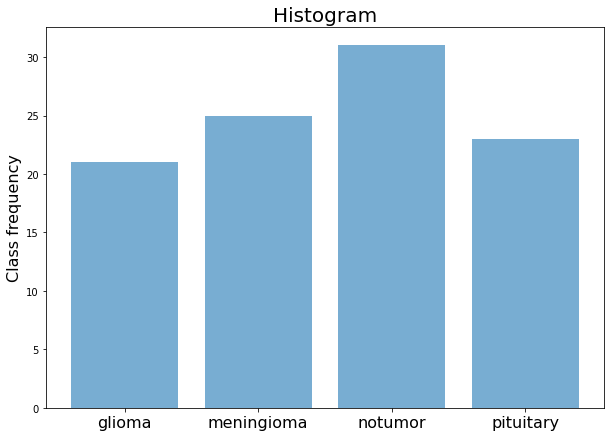

In [ ]:
# to display a shape object,
# library that processes the figure in the jupiter notebook

%matplotlib inline


# Set the default size of the drawing
plt.rcParams['figure.figsize'] = (10.0, 7.0)


# Drawing histogram of 4 classes with sample numbers
# Defining a shape object
figure = plt.figure()


# Drawing a bar chart
plt.bar(classesIndexes, classesFrequency, align='center', alpha=0.6)


# Naming the Y axis
plt.ylabel('Class frequency', fontsize=16)


# Name each Bar along the X-axis
plt.xticks(classesIndexes, labels, fontsize=16)


# Naming the plot
plt.title('Histogram', fontsize=20)


# Save the chart
figure.savefig('histogram.png', transparent=True, dpi=500)


# Showing the plot
plt.show()

# 🎰 Generating the Projected Vector

In [ ]:
# Copying the array with indexes of True classes
y_predicted = np.copy(y_true)

In [ ]:
# Randomly selecting 80% of the classes to be changed
ii = np.random.randint(low=0, high=len(y_true), size=int(0.8 * len(y_true)), dtype=int)



# Selected indexes are displayed
print(ii)

[36  6  2 70 74 24 60 44  3 91  9  2 42 42  1 27 13 85 89 90 31 56 47 86
 61 99  7 73 43 14 15 53 27 38 36 10 68 86  5 39 33 27 45 68 71 29 92 92
 55 43 24 50 49 81 46 25 98 93 60 92  4 13 30 47 93 36 77 44 70 22 27  9
 41 58 17 82 38 30 67 48]


In [ ]:
# Iterate through selected directories and replace them with directories of other classes
for i in ii:
    # Creating new class directory
    y_predicted[i] = np.random.randint(low=0, high=4, dtype=int)
    
    
   
    # Difference between indexes of real classes and Predicted index
    print('index = {0:2d}, True class => {1}, {2} <= Predicted class'.
          format(i, y_true[i], y_predicted[i]))

index = 36, True class => 1, 3 <= Predicted class
index =  6, True class => 3, 0 <= Predicted class
index =  2, True class => 1, 2 <= Predicted class
index = 70, True class => 2, 2 <= Predicted class
index = 74, True class => 1, 0 <= Predicted class
index = 24, True class => 2, 0 <= Predicted class
index = 60, True class => 2, 3 <= Predicted class
index = 44, True class => 2, 1 <= Predicted class
index =  3, True class => 0, 3 <= Predicted class
index = 91, True class => 0, 2 <= Predicted class
index =  9, True class => 2, 0 <= Predicted class
index =  2, True class => 1, 3 <= Predicted class
index = 42, True class => 2, 2 <= Predicted class
index = 42, True class => 2, 2 <= Predicted class
index =  1, True class => 1, 2 <= Predicted class
index = 27, True class => 1, 0 <= Predicted class
index = 13, True class => 1, 3 <= Predicted class
index = 85, True class => 0, 2 <= Predicted class
index = 89, True class => 3, 1 <= Predicted class
index = 90, True class => 1, 0 <= Predicted class


# 🧮 Calculating the Complexity Matrix

In [ ]:
# The Confusion Matrix is ​a two-dimensional matrix that visualizes performance,
# and makes it easy to see confusion between classes,
# Each row represents a set of real True classes.
# Each column represents the estimated number of classes.


# Computational Confusion Matrix to evaluate the accuracy of classification
c_m = confusion_matrix(y_true, y_predicted)

# Representing Confusion Matrix as a 2D Numpy array
print(c_m)

[[ 8  3  5  5]
 [ 2 12  8  3]
 [ 7  2 19  3]
 [ 1  3  0 19]]


# 👁️‍🗨️ Viewing the Complexity Matrix

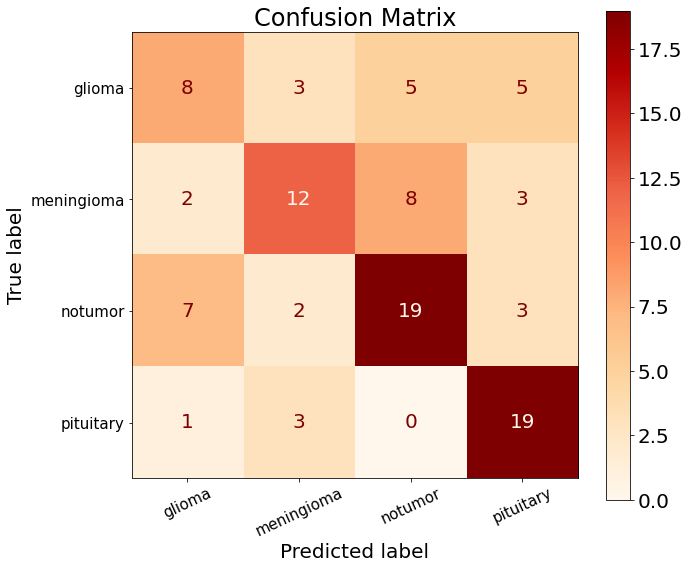

In [ ]:

%matplotlib inline


# Set the default font size used in drawing
plt.rcParams['figure.figsize'] = (10.0, 9.0)
plt.rcParams['font.size'] = 20


# Implementing a visualization of the Confusion Matrix
display_c_m = ConfusionMatrixDisplay(c_m, display_labels=labels)


# Drawing the Confusion Matrix
# Setting the color map to be used
display_c_m.plot(cmap='OrRd', xticks_rotation=25)
# Other possible options for colour map are:
# 'autumn_r', 'Blues', 'cool', 'Greens', 'Greys', 'PuRd', 'copper_r'


# Adjust font size for xticks and yticks
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


# Naming the plot
plt.title('Confusion Matrix', fontsize=24)


# Saving
plt.savefig('confusion_matrix.png', transparent=True, dpi=500)


# 
plt.show()

In [ ]:
# Showing classification metrics
print(classification_report(y_true, y_predicted))

              precision    recall  f1-score   support

           0       0.44      0.38      0.41        21
           1       0.60      0.48      0.53        25
           2       0.59      0.61      0.60        31
           3       0.63      0.83      0.72        23

    accuracy                           0.58       100
   macro avg       0.57      0.57      0.57       100
weighted avg       0.57      0.58      0.57       100



#   ⚖️ Sınıflandırma Raporu